# Use: Tests of `BenamouBrenier.py`

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
from warnings import warn
from tqdm.notebook import tqdm,trange # to display loading bars
%load_ext autoreload
%autoreload 2

from BenamouBrenier import TransportProblem
from transport import gaussian_transport, gaussian_discreatization, random_gaussian_parameters

In [65]:
def torus_dist2(x,y):
    dist = np.min([(x[0]-y[0])**2, (1-np.abs(x[0]-y[0]))**2])
    dist = dist + np.min([(x[1]-y[1])**2, (1-np.abs(x[1]-y[1]))**2])
    return dist

d = torus_dist2(np.array([0,0.5]), np.array([0.75,0.5]))
np.sqrt(d)

0.25

## BenamouBrenier.solve

TransportProblem object initialized.


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/benoitmuller/Documents/GitHub/Computational-Optimal-Transport/poisson.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  u_vect,res,rank,s = np.linalg.lstsq(A.toarray(),b)


Benamou-Brenier method converged to tolerance with res = 1.4660078453130556e-07


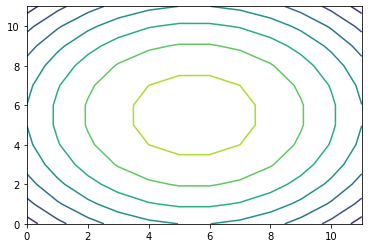

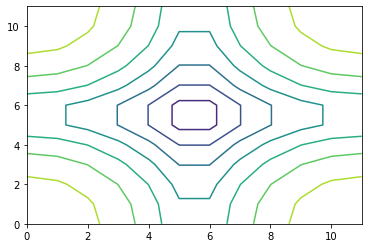

In [102]:
%matplotlib inline
rng = np.random.default_rng(123)
from scipy.stats import multivariate_normal
from matplotlib.widgets import Slider
N=12
T=N
mesh= np.array(np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N)))

#mean1, cov1 = random_gaussian_parameters(2,rng)
#mean2, cov2 = random_gaussian_parameters(2,rng)
mean1 , cov1 = 0.5 * np.ones((2)) , np.eye(2) / 10
mean2 , cov2 = 1 * np.ones((2)) , np.eye(2) / 10

mu,nu = np.empty((N,N)),np.empty((N,N))
for idx in np.ndindex((N,N)):
    mu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean1)/10)
    nu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean2)/10)
mu = mu/np.sum(mu)
nu = nu/np.sum(nu)
plt.figure()
plt.contour(mu)
plt.figure()
plt.contour(nu)
prob1 = TransportProblem(mesh,mu,nu,T,tau=1.0)
prob1.solve(maxiter=1)

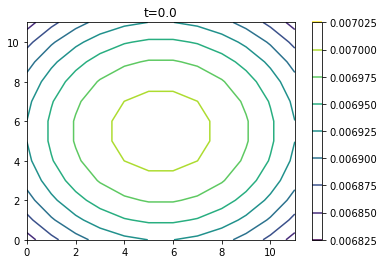

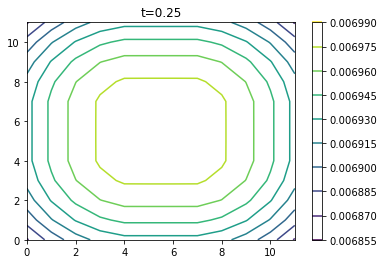

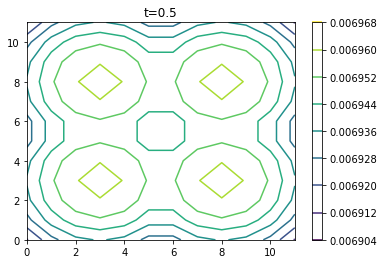

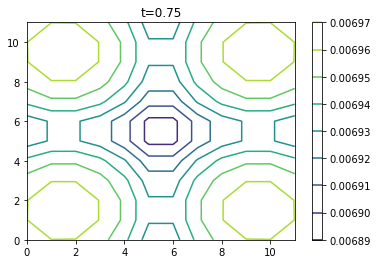

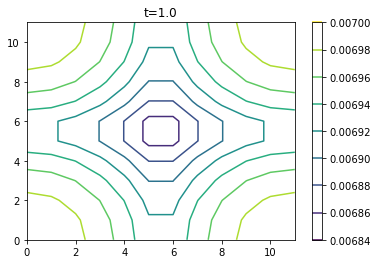

In [100]:
%matplotlib inline
tt= np.linspace(0,1,5)
prob1.plot(tt)

In [51]:
%matplotlib
fig = prob1.plot()

Using matplotlib backend: MacOSX


## Poisson step
- used centered $O(h^2)$ finite difference, with ghost point for Neumann bc
- the source term is a divergence and we need acces to $\nabla\phi$, done with centered $O(h^2)$ finite difference except on the Numann boundary where it is $O(h)$
- System underdetermined, used kernel orthogonality

## Steps
- **Projection Step**:
    - Analytic solution complicated and numerically instable. reduce the problem to 1D (grid-wise), and use Newton method to solve the polynomial equation of orthogonality. [Algorithms for projecting points onto conics](https://www.sciencedirect.com/science/article/pii/S0377042713001398#s000005)
    - choice of the initial point ([desmos graphic](https://www.desmos.com/calculator/nj6gcjfbaq)) to get the right zero.
- **Dual Step**: easy
- **Poisson Step**:
- What is the Domain $\Omega\subset\mathbb{R}^d$, should contain the support of $\mu$ and $\nu$?
- gaussian transport
    - restrict to an ellipsis support of $\mu$ and renormalise (polar coord and 1D normal distribution)
    - the transport map is still optimal and lead to an ellipsis support, and is still optimal.

## 3D Poisson solver
Solver of the 3D poisson equation with mixed boundary condition that are heterogenous Neumann in the first dimension and periodic in the last two ones.

In [39]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange
%matplotlib inline
%load_ext autoreload
%autoreload 2

from poisson import *

nn = 7 + np.arange(10)
order = "F"

#uex = lambda x,y,z: -1 + x**2 + np.sin(2*np.pi*y) + np.sin(4*np.pi*z)
#f = lambda x,y,z:  0*x + 2 - (2*np.pi)**2 * np.sin(2*np.pi*y) - (4*np.pi)**2 * np.sin(4*np.pi*z)

uex = lambda x,y,z: x + np.sin(2*np.pi*y) + np.sin(4*np.pi*z)
f = lambda x,y,z:  0*x - (2*np.pi)**2 * np.sin(2*np.pi*y) - (4*np.pi)**2 * np.sin(4*np.pi*z)

err = np.zeros((len(nn),2))
for i,n in enumerate(nn):
    x=np.linspace(0,1,n)[:,None,None]
    y=np.linspace(0,1,n)[None,:,None]
    z=np.linspace(0,1,n)[None,None,:]
    uex_vect = uex(x,y,z)
    f_vect = f(x,y,z)
    g_vect = np.array([np.ones((n,n)), np.ones((n,n))])

    u,A,b,u_vect,res,rank,s = poisson(f_vect,g_vect)

    u = u - np.mean(u) + np.mean(uex_vect)
    err[i,0],err[i,1] = np.max(np.abs(u-uex_vect)),np.mean(np.abs(u-uex_vect))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/benoitmuller/Documents/GitHub/Computational-Optimal-Transport/poisson.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  u_vect,res,rank,s = np.linalg.lstsq(A.toarray(),b)


[[0.30400893 0.11990439]
 [0.24771353 0.10796312]
 [0.24875667 0.10119469]
 [0.24774635 0.09666212]
 [0.23705514 0.0924242 ]
 [0.23819429 0.08848518]
 [0.22346499 0.08484602]
 [0.2224727  0.08107563]
 [0.21085559 0.07768565]
 [0.20624941 0.07450744]]
integral of u:            0.5
integral of uex:          0.5000000000000001
max-norm of the error:    0.2062494114364446
L1-norm of the error:    0.07450744000772003
residual 2-norm:         4.630253657082984e-29


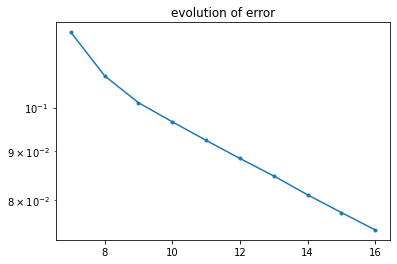

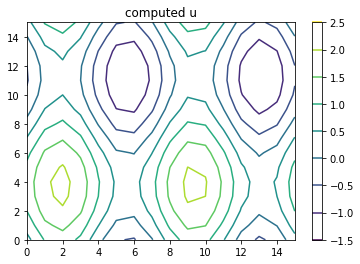

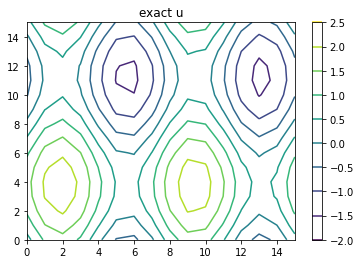

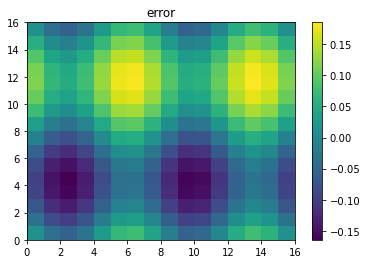

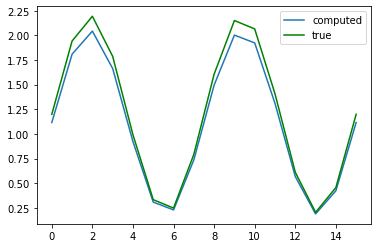

In [41]:
%matplotlib inline

plt.semilogy(nn,err[:,1],'.-')
plt.title("evolution of error")

print(err)
print("integral of u:           ", np.sum(u) / n**3)
print("integral of uex:         ", np.sum(uex_vect) / n**3)
print("max-norm of the error:   ", np.max(np.abs(u-uex_vect)))
print("L1-norm of the error:   ", np.mean(np.abs(u-uex_vect)))
print("residual 2-norm:        ", np.linalg.norm(res))

i= 5
plt.figure()
plt.title("computed u")
plt.contour(u[i,:,:])
plt.colorbar()

plt.figure()
plt.title("exact u")
plt.contour(uex_vect[i,:,:])
plt.colorbar()

plt.figure()
plt.title("error")
plt.pcolormesh((u-uex_vect)[i,:,:])
plt.colorbar()

plt.figure()
plt.plot(u[i,i,:])
plt.plot(uex_vect[i,i,:],"green")
plt.legend(["computed","true"])


In [3]:
%matplotlib
plt.figure()
s = plot_slider(u)

Using matplotlib backend: <object object at 0x7fcc092570b0>
